In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

# Models

## Graph Convolution

In [2]:
# A simple GNN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## Message passing

In [41]:
def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight

class MPNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__(aggr="add")                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_message = nn.Linear(in_channels, out_channels, # weights 𝚯_1
                                     bias=False)
        self.lin_update = nn.Linear(in_channels, out_channels,  # weights 𝚯_2
                                    bias=True)                  # the bias vector 𝐛

    def forward(self, x, edge_index, edge_weight=None):
        # 0. if GSO not already computed, compute it here
        if edge_weight is None:
          _, edge_weight = random_walk_matrix(edge_index)
        # 1. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_message(x)  # we can project here with isotropic GNNs
        # 2. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        m_i = self.propagate(edge_index, m=m_ji, edge_weight=edge_weight)
        # 3. h_𝑖 = tanh(x_i𝚯_2 + m_i + 𝐛)
        h_i = torch.nn.GELU()(self.lin_update(x) + m_i)
        return h_i

    def message(self, m_j, edge_weight):
        # m_j has shape [num_edges, num_features]
        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖
    
class MPNNClassifier(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_classes: int, num_iterations: int = 1):
        super().__init__()
        self.mpnn = MPNN(in_channels, out_channels)
        self.classifier = nn.Linear(out_channels, num_classes)
        self.num_iterations = num_iterations

    def forward(self, x, edge_weight=None):
        # Pass the input through the MPNN for a number of iterations
        edge_index = x.edge_index
        x = x.x
        for _ in range(self.num_iterations):
            x = self.mpnn(x, edge_index, edge_weight)
        # Pass the output through the classifier
        out = self.classifier(x)
        # Apply softmax to get probabilities
        out = F.softmax(out, dim=1)
        return out

## Cooperative

In [42]:
def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight

class action_net(torch.nn.Module):
    """Classify a node feature vector into {S,L,B,I}."""
    def __init__(self, num_features: int):
        super().__init__()
        self.lin_0 = torch.nn.Linear(num_features, num_features)
        self.lin_1 = torch.nn.Linear(num_features, num_features)
        self.lin_2 = torch.nn.Linear(num_features, 4)

    def forward(self, x):
        out = self.lin_0(x)
        out = torch.nn.ReLU()(out)
        out = self.lin_1(out)
        out = torch.nn.ReLU()(out)
        out = self.lin_2(out)
        out = torch.nn.ReLU()(out)
        out = F.log_softmax(out, dim=1)
        return out

class CoGNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, action_net_type: str="sum"):
        super().__init__(aggr=action_net_type)                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_0_message = nn.Linear(in_channels, in_channels, # weights 𝚯_1
                                        bias=True)
        self.lin_1_message = nn.Linear(in_channels, out_channels, # weights 𝚯_1
                                        bias=True)
        self.lin_update = nn.Linear(in_channels, out_channels,  # weights 𝚯_2
                                    bias=True)                  # the bias vector 𝐛
        self.action_net = action_net(in_channels)
        # self.environment_net = environment_net

    def forward(self, x, edge_index, edge_weight=None):
        # 0. if GSO not already computed, compute it here
        if edge_weight is None:
          _, edge_weight = random_walk_matrix(edge_index)
        # 1. a_i = action_net(x_i)
        p_i = self.action_net(x) # probabilities for action selection {S, L, B, I}
        # Sample an action using the straight-through Gumbel-softmax estimator
        action = F.gumbel_softmax(p_i, hard=True)
        # Unless the action is S or B, the sent message is zero
        send = action[:, 0] + action[:, 2]
        # Unless the action is S or L, the received message is zero
        receive = action[:, 0] + action[:, 1]
        # 2. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_0_message(x) # we can project here with isotropic GNNs
        m_ji = torch.nn.GELU()(m_ji)
        m_ji = self.lin_1_message(m_ji)
        m_ji = torch.nn.GELU()(m_ji)
        m_ji = m_ji * send.view(-1, 1)
        # 3. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        m_i = self.propagate(edge_index, m=m_ji, edge_weight=edge_weight)
        # 4. h_𝑖 = gelu(x_i𝚯_2 + m_i + 𝐛) or gelu(x_i𝚯_2)
        m_i = m_i * receive.view(-1, 1)
        h_i = torch.nn.GELU()(self.lin_update(x) + m_i)
        return h_i

    def message(self, m_j, edge_weight):
        # m_j has shape [num_edges, num_features]
        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖
    
class CoGNNClassifier(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_classes: int, num_iterations: int = 1):
        super().__init__()
        self.CoGNN = CoGNN(in_channels, out_channels)
        self.classifier_layer_0 = nn.Linear(out_channels, num_classes)
        self.classifier_layer_1 = nn.Linear(num_classes, num_classes)
        self.num_iterations = num_iterations

    def forward(self, x, edge_weight=None):
        # Pass the input through the MPNN for a number of iterations
        edge_index = x.edge_index
        x = x.x
        for _ in range(self.num_iterations):
            x = self.CoGNN(x, edge_index, edge_weight)
        # Pass the output through the classifier
        out = self.classifier_layer_0(x)
        out = torch.nn.GELU()(out)
        out = self.classifier_layer_1(out)
        out = torch.nn.GELU()(out)
        # Apply softmax to get probabilities
        out = F.softmax(out, dim=1)
        return out

# Create Data

## Custom

In [12]:
def label_data_1(G, num_nodes, node_features):
    # Create random labels for each node (e.g., 3 interest groups)
    labels = np.zeros(num_nodes)

    # Iterate over each node
    for node in range(num_nodes):
        # Get the neighbors of the current node
        neighbors = list(G.neighbors(node))

        # Classify the node based on the sum of features
        feature_1 = node_features[node][0] + node_features[neighbors, 0].sum()
        feature_2 = node_features[node][1] + node_features[neighbors, 1].sum()
        
        # Classify the node based on the sum of features
        if feature_1 < 0 and feature_2 < 0:
            labels[node] = 1
        elif feature_1 > 0 and feature_2 < 0:
            labels[node] = 2
        elif feature_1 > 0 and feature_2 > 0:
            labels[node] = 2
        elif feature_1 > 0 and feature_2 > 0:
            labels[node] = 3

    # Convert the labels to a PyTorch tensor
    labels = torch.tensor(labels, dtype=torch.long)

    return labels

def label_data_0(G, num_nodes, node_features):
    # Create random labels for each node (e.g., 3 interest groups)
    labels = np.zeros(num_nodes)

    # Iterate over each node
    for node in range(num_nodes):

        # Classify the node based on the sum of features
        feature_1 = node_features[node][0]
        feature_2 = node_features[node][1]
        
        # Classify the node based on the sum of features
        if feature_1 < 0 and feature_2 < 0:
            labels[node] = 1
        elif feature_1 >= 0 and feature_2 < 0:
            labels[node] = 2
        elif feature_1 < 0 and feature_2 >= 0:
            labels[node] = 2
        elif feature_1 >= 0 and feature_2 >= 0:
            labels[node] = 3

    # Convert the labels to a PyTorch tensor
    labels = torch.tensor(labels, dtype=torch.long)

    return labels

def label_data_random(G, num_nodes, node_features):
    # Create random labels for each node (e.g., 3 interest groups)
    labels = np.random.randint(0, 3, num_nodes)

    # Convert the labels to a PyTorch tensor
    labels = torch.tensor(labels, dtype=torch.long)

    return labels
    
def generate_dataset(num_graphs=100, num_nodes=10, num_node_features=2, num_classes=3):
    dataset = []
    graphs = []
    for i in range(num_graphs):
        # Create random node features between -10 and 10
        node_features = torch.randint(low=-10, high=11, size=(num_nodes, num_node_features), dtype=torch.float)

        # Create a simple graph using networkx and convert it to edge index
        G = nx.erdos_renyi_graph(n=num_nodes, p=0.1)
        edge_index = torch.tensor([list(edge) for edge in G.edges], dtype=torch.long).t().contiguous()

        # Create random labels for each node (e.g., 3 interest groups)
        labels = label_data_1(G, num_nodes, node_features)

        # Create a PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, y=labels, graph=G)

        # Append the data to the list of datasets
        dataset.append(data)

        # Append the graph to the list of graphs
        graphs.append(G)
        
    return dataset, graphs

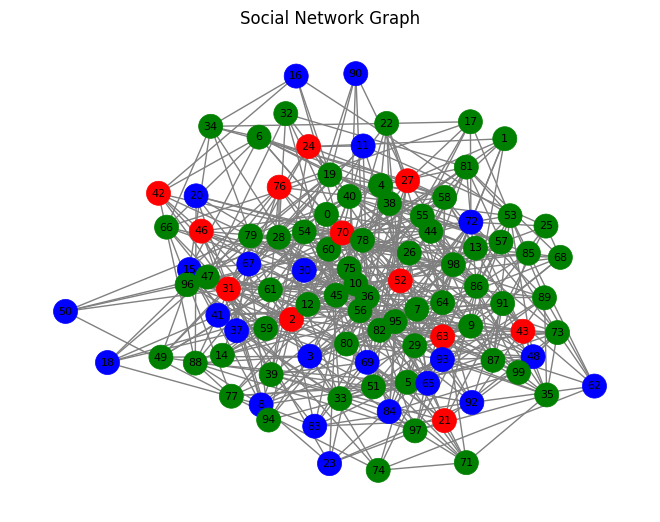

In [13]:
num_graphs=10
num_nodes = 100
num_node_features = 2
num_classes=3

dataset, graphs = generate_cuda_dataset(num_graphs=num_graphs, num_nodes=num_nodes, num_node_features=num_node_features, num_classes=num_classes)

# Draw the graph with different colors for each class
node_colors = ['red', 'green', 'blue']
node_color = [node_colors[label-1] for label in dataset[0].y.numpy()]

nx.draw(graphs[0], with_labels=True, node_color=node_color, edge_color='gray', node_size=300, linewidths=0.5, font_size=8)
plt.title("Social Network Graph")
plt.show()


x is a n by m matrix representing the features of each node. n is the number of nodes, m is the number of features.

edge_index is a 2 by e matrix representing the edges. e is the number of edges.

y is a n by 1 matrix representing the labels of each node.

In [20]:
print("Node features:")
print(dataset[0].x)

print("Edge index:")
print(dataset[0].edge_index)

print("Labels:")
print(dataset[0].y)

Node features:
tensor([[  0.,  -3.],
        [ -7.,   0.],
        [ -4.,  -7.],
        [  5.,   4.],
        [  6.,   8.],
        [  3.,   6.],
        [  9.,   2.],
        [ -8.,   7.],
        [ -6.,  -4.],
        [ 10.,   2.],
        [ -4.,   7.],
        [ -3.,   3.],
        [ -4., -10.],
        [  7.,  -5.],
        [ -1.,   6.],
        [-10.,   0.],
        [ -4.,   3.],
        [ -3.,  -8.],
        [ -6.,  10.],
        [ -4.,   8.],
        [ -7.,  -5.],
        [  5.,   3.],
        [ -2.,   0.],
        [ -2.,   1.],
        [ -3.,  -5.],
        [ -4.,   7.],
        [  3.,  -9.],
        [  8.,   7.],
        [  1.,   8.],
        [  8.,  -1.],
        [  1.,  -5.],
        [ -2.,   5.],
        [  4.,  -1.],
        [-10.,  -7.],
        [ -1.,   7.],
        [  5.,   2.],
        [  7.,   4.],
        [  3.,  -4.],
        [  4.,   5.],
        [ -1.,   4.],
        [  6.,  -4.],
        [ 10.,   9.],
        [  1.,   0.],
        [  2.,  10.],
        [ 10., -1

## Paper Ref

c:\Users\lolis\Documents\UNI\Kurser\master thesis\.venv\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


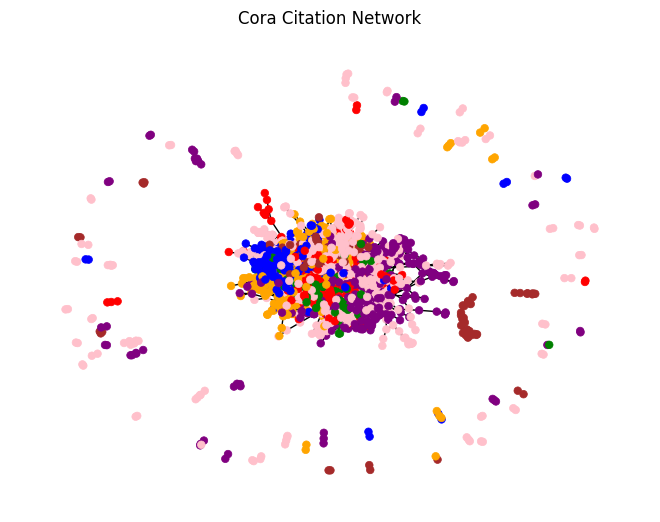

In [3]:
dataset = Planetoid(root='/datasets/Cora', name='Cora')

def to_graph(cora_data):
    G = to_networkx(cora_data, to_undirected=True)
    return G

def visualize(cora_data):
    G = to_graph(cora_data)
    node_colors = ['red', 'green', 'blue', 'pink', 'purple', 'orange', 'brown']
    node_color = [node_colors[label] for label in cora_data.y]

    nx.draw(G, with_labels=False, node_color=node_color, edge_color='black', node_size=30, linewidths=0.5)
    plt.title("Cora Citation Network")

visualize(dataset.data)


In [4]:
# Print the number of classes
num_classes = dataset.num_classes
print("Number of classes:", num_classes)

# Print the number of graphs
num_graphs = len(dataset)
print("Number of graphs:", num_graphs)

# Print the number of nodes
num_nodes = dataset.data.num_nodes
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset.num_node_features
print("Number of node features:", num_node_features)

# Print the data object
print("Data object:", dataset.data)

# Print the edge index
print("Edge index:", dataset.data.edge_index)

# Print the node features
print("Node features:", dataset.data.x)

# Print the labels
print("Labels:", dataset.data.y)

# Print the train, validation, and test masks
train_mask = dataset.data.train_mask
val_mask = dataset.data.val_mask
test_mask = dataset.data.test_mask
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)


Number of classes: 7
Number of graphs: 1
Number of nodes: 2708
Number of node features: 1433
Data object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Edge index: tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
Node features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Labels: tensor([3, 4, 4,  ..., 3, 3, 3])
Train mask: tensor([ True,  True,  True,  ..., False, False, False])
Validation mask: tensor([False, False, False,  ..., False, False, False])
Test mask: tensor([False, False, False,  ...,  True,  True,  True])


# Train model

In [43]:
# Initialize the model
# model = GCN(num_node_features, num_classes)
model = CoGNNClassifier(num_node_features, num_node_features, num_classes, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# moving the data to GPU

# Create a new list to store the modified dataset
cuda_dataset = []

# Move each element of the original dataset to the GPU and append to cuda_dataset
for data in dataset:
    cuda_data = data.clone()  # Create a deep copy of the data
    cuda_data = cuda_data.to('cuda')
    cuda_data.x = cuda_data.x.to('cuda')
    cuda_data.edge_index = cuda_data.edge_index.to('cuda')
    cuda_data.y = cuda_data.y.to('cuda')
    cuda_dataset.append(cuda_data)

model.to('cuda')

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", cuda_dataset[0].x.device)

Model: CoGNNClassifier(
  (CoGNN): CoGNN(1433, 1433)
  (classifier_layer_0): Linear(in_features=1433, out_features=7, bias=True)
  (classifier_layer_1): Linear(in_features=7, out_features=7, bias=True)
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Model Device: cuda:0
Data Device: cuda:0


In [44]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    avg_loss = 0
    for data in cuda_dataset:
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        # loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / num_graphs
    return avg_loss

def validate():
    model.eval()
    avg_train_accuracy = 0
    avg_val_accuracy = 0
    with torch.no_grad():
        for data in cuda_dataset:
            logits = model(data) # Log probabilities

            # Train accuracy
            train_mask = data.train_mask # Mask of train nodes
            train_logits = logits[train_mask] # Log probabilities of train nodes
            train_labels = data.y[train_mask] # True labels of train nodes
            train_pred = train_logits.max(1)[1] # Predicted labels
            train_correct = train_pred.eq(train_labels).sum().item() # Number of correctly classified nodes
            train_accuracy = train_correct / train_mask.sum().item() # Accuracy
            avg_train_accuracy += train_accuracy / num_graphs # Average accuracy

            # Validation accuracy
            val_mask = data.val_mask # Mask of validation nodes
            val_logits = logits[val_mask] # Log probabilities of validation nodes
            val_labels = data.y[val_mask] # True labels of validation nodes
            val_pred = val_logits.max(1)[1] # Predicted labels
            val_correct = val_pred.eq(val_labels).sum().item() # Number of correctly classified nodes
            val_accuracy = val_correct / val_mask.sum().item() # Accuracy
            avg_val_accuracy += val_accuracy / num_graphs # Average accuracy
            
    return avg_train_accuracy, avg_val_accuracy

# Testing function
def test():
    model.eval()
    avg_accuracy = 0
    with torch.no_grad():
        for data in cuda_dataset:
            logits = model(data) # Log probabilities
            test_mask = data.test_mask # Mask of test nodes
            test_logits = logits[test_mask] # Log probabilities of test nodes
            test_labels = data.y[test_mask] # True labels of test nodes
            pred = test_logits.max(1)[1] # Predicted labels
            correct = pred.eq(test_labels).sum().item() # Number of correctly classified nodes
            accuracy = correct / test_mask.sum().item() # Accuracy
            avg_accuracy += accuracy / num_graphs # Average accuracy
    return avg_accuracy

def visualize_results(graph_num=0):
    model.eval()
    with torch.no_grad():
        data = cuda_dataset[graph_num]
        logits = model(data) # Log probabilities
        test_mask = data.test_mask # Mask of test nodes
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = data.y[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels

        # Draw the graph with different colors for each class
        node_color = []
        # set the color of the nodes based on whether the prediction is correct
        j = 0
        for i in range(len(data.y.cpu().numpy())):
            if test_mask[i]:
                if pred[j] == data.y[i]:
                    node_color.append("green")
                else:
                    node_color.append("red")
                j += 1
            else:
                node_color.append("gray")

        G = to_graph(data)
        nx.draw(G, with_labels=False, node_color=node_color, edge_color='black', node_size=50, linewidths=0.5, font_size=8)
        plt.title("Prediction result")
        plt.show()

In [45]:
# # Test/Train split
# train_size = int(num_nodes * 0.8)
# test_size = num_nodes - train_size
# for data in dataset:
#     # Split the data into training and testing
#     data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#     data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

#     # Randomly select 80% of the nodes for training and the rest for testing
#     indices = torch.randperm(num_nodes)
#     data.train_mask[indices[:train_size]] = True
#     data.test_mask[indices[train_size:]] = True

In [46]:
# Run the training
for epoch in range(1000):
    loss = train()

    if epoch % 10 == 0:
        train_accuracy, val_accuracy = validate()
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1, Loss: -0.1429
Training Accuracy: 0.3000, Validation Accuracy: 0.2620
Epoch 11, Loss: -0.7865
Training Accuracy: 0.7214, Validation Accuracy: 0.4220
Epoch 21, Loss: -0.9977
Training Accuracy: 0.9929, Validation Accuracy: 0.6320
Epoch 31, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6720
Epoch 41, Loss: -0.9991
Training Accuracy: 1.0000, Validation Accuracy: 0.6540
Epoch 51, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6540
Epoch 61, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6480
Epoch 71, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6420
Epoch 81, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6420
Epoch 91, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6440
Epoch 101, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6440
Epoch 111, Loss: -1.0000
Training Accuracy: 1.0000, Validation Accuracy: 0.6440
Epoch 121, Loss: -1.0000
Training Accuracy: 1.0000,

Test Accuracy: 0.6500, Training Accuracy: 1.0000, Validation Accuracy: 0.6460


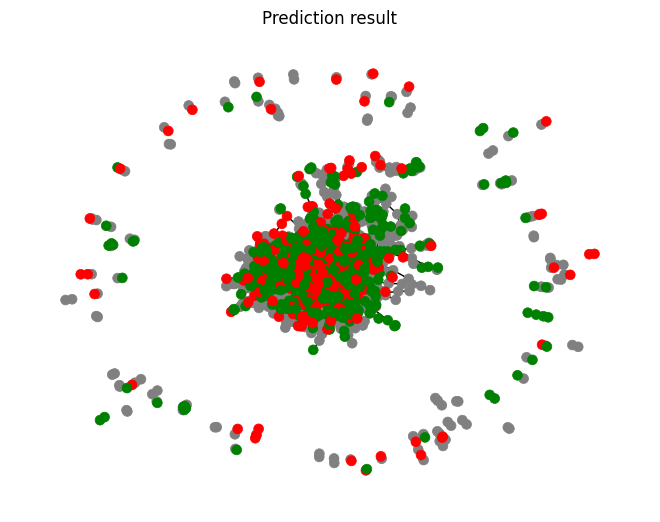

In [47]:
# Test the model
train_accuracy, val_accuracy = validate()
accuracy = test()
print(f'Test Accuracy: {accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

for i in range(1):
    visualize_results(i)

In [24]:
for name, param in model.named_parameters():
    print(f"Name: {name}")
    print(f"Parameter: {param}")
    print("------------------------")


Name: CoGNN.lin_message.weight
Parameter: Parameter containing:
tensor([[-0.1559,  0.1516,  0.0919,  ...,  0.0999,  0.0730,  0.1283],
        [ 0.0641,  0.1188,  0.0814,  ...,  0.1175,  0.1700,  0.1195],
        [ 0.1473, -0.0805,  0.1931,  ..., -0.1149, -0.0604, -0.1042],
        ...,
        [ 0.1018, -0.0670,  0.1672,  ...,  0.1241,  0.1348, -0.1090],
        [-0.0611,  0.1180, -0.1576,  ...,  0.1019,  0.0402,  0.1246],
        [ 0.0824,  0.1509, -0.1709,  ...,  0.1155,  0.1084,  0.1383]],
       device='cuda:0', requires_grad=True)
------------------------
Name: CoGNN.lin_update.weight
Parameter: Parameter containing:
tensor([[-0.1394, -0.1288, -0.1510,  ...,  0.0051,  0.2246, -0.1357],
        [-0.1745, -0.1840, -0.1938,  ...,  0.0088,  0.1349,  0.1271],
        [ 0.0326,  0.0015,  0.0423,  ...,  0.0248,  0.1856,  0.0815],
        ...,
        [ 0.0937,  0.0956, -0.0556,  ..., -0.0019,  0.1718,  0.1459],
        [-0.1747, -0.1552, -0.0086,  ..., -0.0233, -0.1329,  0.1411],
       